QUESTIONS-
What is the trade-off of resizing? If you shrink an image of a
crowded street too much to make it faster, what critical information
might you lose?
ANS-Makes the process faster but small details may be lost like in a crowded street we can loose the data about small things on road,some persons,cars etc.

When would grayscaling be a bad idea? Name a detection task
where color is the most important feature. (e.g., identifying traffic
light status, sorting ripe vs. unripe fruit).
Ans-
 grayscaling could be a bad idea when the most important feature is colour like in idetifying traffic lights the most important thing here are the three colours red,yellow,green so if we would do gray scaling the most important feature will be lost other examples may include sports jersey or any task where we have to identify on the bases of colour one more example is phones variants based on the colour.

Blurring intentionally destroys information. Imagine you are building a
system to read license plates from a security camera. How could blurring be
helpful? How could it be harmful if you apply too much?
Ans-it will be helpful in removing the background noise it will be more focused on what we need means the license plate of the vehicle it will make the character of the vehicle plate clear it is harmful if we will do it too much as the information means the characters of the plate may be lost also the numbers and the characters may be merged.



In [5]:
!pip install ultralytics opencv-python
from ultralytics import YOLO
model = YOLO('yolov3u.pt')

In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


In [10]:
print("Downloading YOLOv3 files...")
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
!wget https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
!wget https://github.com/pjreddie/darknet/raw/master/data/coco.names
print("Download complete.")

--2025-08-28 12:24:31--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/e42c2500-9016-11ea-92ba-11df9f79f31b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-28T13%3A21%3A35Z&rscd=attachment%3B+filename%3Dyolov3.weights&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-28T12%3A21%3A01Z&ske=2025-08-28T13%3A21%3A35Z&sks=b&skv=2018-11-09&sig=pmPrkxcX8FGTfYodplqJJN6Od3fLXVYTlb%2BA%2BHrFVK4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjM4NDE3MSwibmJmIjoxNzU2MzgzODcxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJ

In [11]:
weights_path = "yolov3.weights"
cfg_path = "yolov3.cfg"
names_path = "coco.names"

if os.path.exists(weights_path + ".1"):
    os.rename(weights_path + ".1", weights_path)
if os.path.exists(cfg_path + ".1"):
    os.rename(cfg_path + ".1", cfg_path)
if os.path.exists(names_path + ".1"):
    os.rename(names_path + ".1", names_path)


In [12]:
print("Loading class names...")
def load_names(names_path):
    with open(names_path, "r") as f:
        return [c.strip() for c in f.readlines()]

classes = load_names(names_path)
print(f"Loaded {len(classes)} class names.")


Loading class names...
Loaded 80 class names.


In [13]:
print("Loading YOLOv3 network...")
try:
    net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
    print("YOLOv3 network loaded successfully.")

    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU backend.")

    def get_output_layer_names(net):
        layer_names = net.getLayerNames()
        output_layers = []
        for i in net.getUnconnectedOutLayers():
            if isinstance(i, list):
                output_layers.append(layer_names[i[0] - 1])
            else:
                output_layers.append(layer_names[i - 1])
        return output_layers

    output_layers = get_output_layer_names(net)

except Exception as e:
    print(f"Error loading YOLOv3 network: {e}")
    exit()


Loading YOLOv3 network...
YOLOv3 network loaded successfully.
Using CPU backend.


In [14]:
image_path = "car.png"
print(f"Loading image: {image_path}")
img = cv2.imread(image_path)

if img is None:
    print(f"Error: Image not found at {image_path}.")
    exit()

h, w = img.shape[:2]
print(f"Image loaded with dimensions: {w}x{h}")


Loading image: car.png
Image loaded with dimensions: 892x880


In [15]:
input_size = 608
blob = cv2.dnn.blobFromImage(img, 1/255.0, (input_size, input_size), swapRB=True, crop=False)
net.setInput(blob)

print("Performing forward pass...")
outputs = net.forward(output_layers)
print("Forward pass complete.")


Performing forward pass...
Forward pass complete.


In [16]:
boxes, confidences, class_ids = [], [], []
conf_thresh = 0.2

for out in outputs:
    for det in out:
        scores = det[5:]
        class_id = int(np.argmax(scores))
        conf = float(scores[class_id])

        if conf > conf_thresh:
            cx, cy, bw, bh = det[:4] * np.array([w, h, w, h])
            x, y = int(cx - bw/2), int(cy - bh/2)

            boxes.append([x, y, int(bw), int(bh)])
            confidences.append(conf)
            class_ids.append(class_id)

nms_thresh = 0.4
print(f"Found {len(boxes)} raw detections. Applying NMS...")
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, nms_thresh)
print(f"After NMS, {len(idxs)} detections remaining.")


Found 21 raw detections. Applying NMS...
After NMS, 2 detections remaining.


In [17]:
font = cv2.FONT_HERSHEY_SIMPLEX
colors = np.random.uniform(0, 255, size=(len(classes), 3))

print("Drawing bounding boxes and labels...")
if len(idxs) > 0:
    for i in np.array(idxs).flatten():
        x, y, bw, bh = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = colors[class_ids[i]]

        cv2.rectangle(img, (x, y), (x+bw, y+bh), color, 2)
        font_scale, thickness = 0.8, 2
        (tw, th) = cv2.getTextSize(label, font, fontScale=font_scale, thickness=thickness)[0]
        cv2.rectangle(img, (x, y - th), (x + tw, y + 5), color, cv2.FILLED)
        cv2.putText(img, label, (x, y - 5), font, font_scale, (0,0,0), thickness)

print("Visualization complete.")


Drawing bounding boxes and labels...
Visualization complete.


Saved: results.png


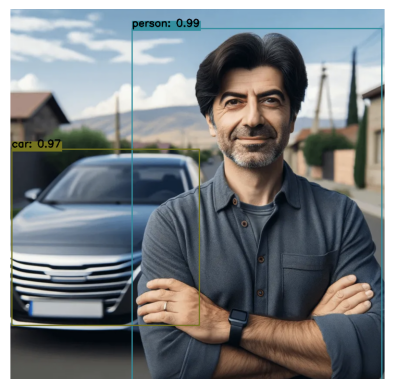

In [18]:
save_path = "results.png"
cv2.imwrite(save_path, img)
print("Saved:", save_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
